In [1]:
using CairoMakie;
using DelimitedFiles, Statistics, Glob, LaTeXStrings, StatsBase, LinearAlgebra, SparseArrays, Distances, LazySets,  MultivariateStats;
using Measures: mm
include("final_analysis_library.jl");

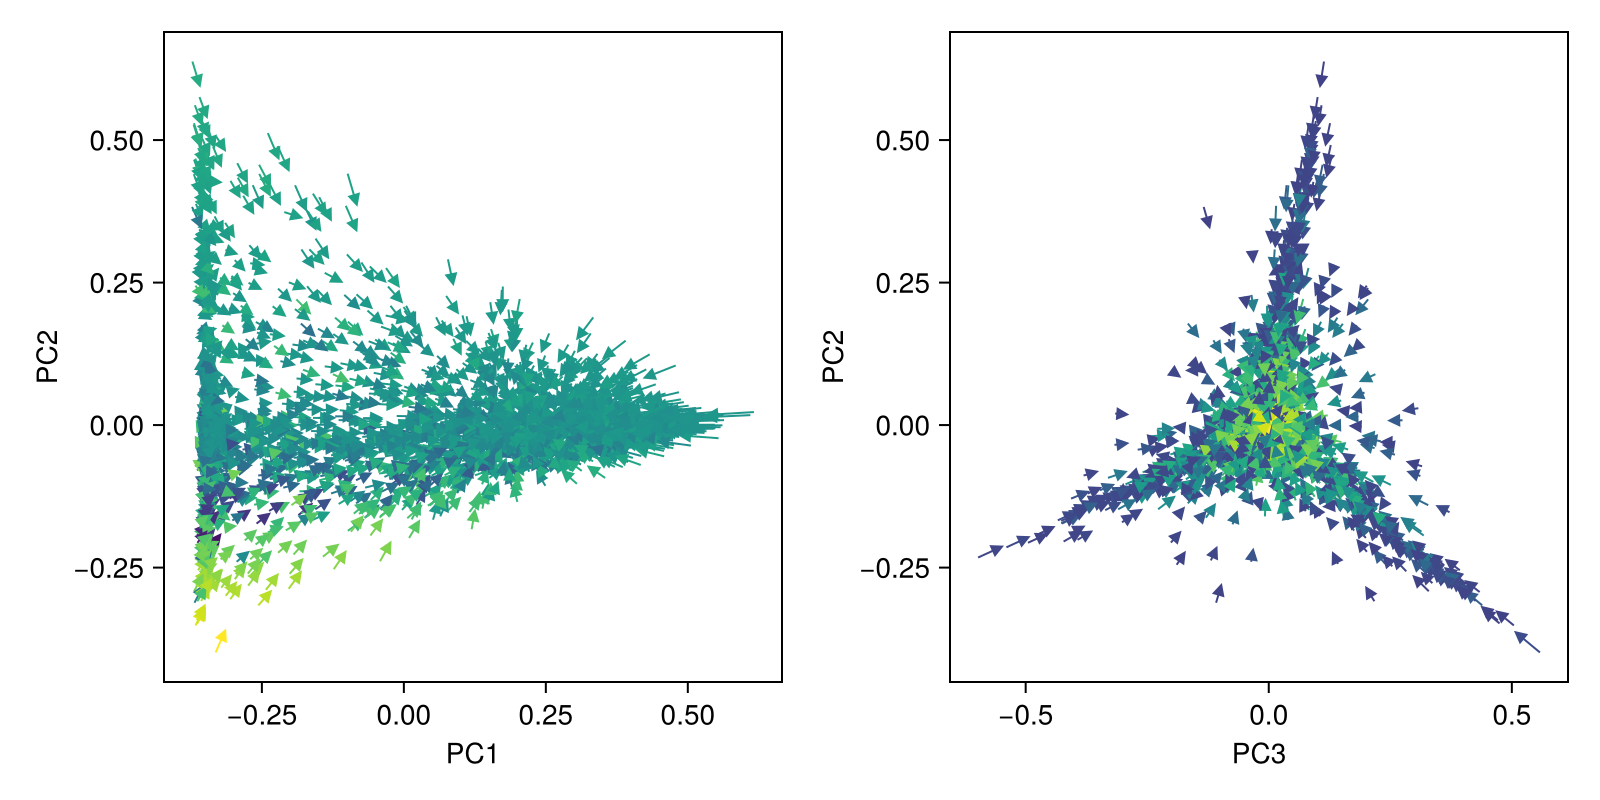

In [2]:
#simulation params
L = 8
M = 100
B = 1;
nu = 0.005;
Delta = 4.;
F0 = 1.; 

K = 4
pk = 0.2

ncopies = 100
tini = 75
nsteps = 200
dt = 50

N = 128

folder = "../data/persistent/Delta$(Delta)_F0$(F0)_nu$(nu)_N$(N)_M$(M)_B1_L$(L)_pers0.0/half_fixed/long_K$(K)_pk$(pk)/";
sfolder = folder*"zeros/sample_1/"
fieldmatrix = readdlm(sfolder*"fieldmatrix.txt",header=true)[1][:,2:end];
        
means = mean(fieldmatrix,dims=1)
vars = var(fieldmatrix,dims=1);

F,V,G = get_FVG(means,vars,L,K)

init="ones/"

Xtr = get_muller_tot(folder*init,"saved_snaps/",ncopies,L,nsteps,tini,dt)./N

P = fit(PCA, Xtr; maxoutdim=3)
v1 = reshape(eigvecs(P)[:,1],(1,2^L))
v2 = reshape(eigvecs(P)[:,2],(1,2^L))
v3 = reshape(eigvecs(P)[:,3],(1,2^L))

Y = predict(P,Xtr);

Y1,Y2,Y3 = Y[1,:], Y[2,:], Y[3,:]

reF = Float64.(reshape(F,(1,2^L)))
reV = Float64.(reshape(V,(1,2^L)))
reG = Float64.(reshape(G,(1,2^L)));

lap = lap_hypercube(L)

dr_pc1, dr_pc2, dr_pc3 = vector_field(Xtr,reF,reV,nu,lap,N,v1,v2,v3);

sk = 5
f = Figure(size=(800, 400))
ax = [Axis(f[1,i], xgridvisible=false, ygridvisible=false) for i in 1:2]
arrows!(ax[1],Y1[1:sk:end],Y2[1:sk:end],dr_pc1[1:sk:end].*2 ./N,dr_pc2[1:sk:end].*2 ./N,color=Y3[1:sk:end],colorrange=(minimum(Y3),maximum(Y3)),alpha=0.8)
arrows!(ax[2],Y3[1:sk:end],Y2[1:sk:end],dr_pc3[1:sk:end].*2 ./N,dr_pc2[1:sk:end].*2 ./N,color=Y1[1:sk:end],colorrange=(minimum(Y3),maximum(Y3)),alpha=0.8)
ax[1].xlabel = "PC1"
ax[1].ylabel = "PC2"
ax[2].xlabel = "PC3"
ax[2].ylabel = "PC2"

save("../data/plots/SI_vector_fields.pdf",f)
f